# Generic Network Coordinates

## Considerations

__Goal:__ Generalize a Res1D object into a network representation. We call this representation _Generic Network Coordinates_ (GNC).

(This notebook is based on `Res1D` format but it is assumed that it will be possible to reuse a major part of the logic to other standard network formats.)

- A `Res1D` file encapsulates a complex structure with multiple layers/dimensions (quantities, reaches, nodes, catchments). This structure is arbitrary and specific to MIKE1D.
- When using `modelskill`, a user is interested in a small subset of all the information present in a `Res1D` file.
    - The number of measured locations might significantly vary: distribution systems might work with hundreds of sensors, whereas collection systems typically work with only a few.
- In reality, most of the measurements will be taken near the nodes.
- Users are familiar with the nomenclature of a `Res1D` object and some of its idiosyncracies (e.g. gridpoints might "overlap" with nodes).
- `modelskill` will accept coordinates based on GNC, `mikeio1d` will offer functionality to map network formats (`Res1D`, `EPANET`, ...) to GNC.
- In GNC, every node will have an ID and a single associated timeseries of the quantity

## Contributions

- **Multi-backend network framework** supporting Res1D with extensible architecture for EPANET and custom formats
- **Flexible coordinate mapping** supporting nodes, edge breakpoints, and edge endpoints ("start"/"end")
- **Bidirectional mapping** with `find()` and `recall()` methods for coordinate transformation
- **Batch operations** enabling lookup of multiple coordinates simultaneously
- **Data preservation** maintaining all timeseries and boundary information from original network
- **NetworkX integration** leveraging graph algorithms, visualization, and analysis capabilities
- **Comprehensive error handling** with informative messages for invalid coordinates or missing elements
- **Unified nomenclature** standardizing network concepts (node, edge, distance) across formats

## Future

- Including in/out attributes in nodes (accounting for adjacent gridpoints)
- Including catchments
- Include other network architectures


![](../images/docs/res1d_mapping.png)

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from mikeio1d import NetworkMapper

## Usage

The `NetworkMapper` class transforms network formats into a generic representation. Currently supports Res1D with planned support for EPANET and custom formats.

In [2]:
res1d_path = "../tests/testdata/network.res1d"
mapper = NetworkMapper(res1d_path)
network = mapper.map_network()

The `GenericNetwork` leverages `networkx` functionality via `network.graph`.

Res1D stores data in nodes and gridpoints. Our generic network represents both as nodes. Since gridpoints at reach endpoints overlap with actual nodes in 1D space, we store this overlapping data in a `boundary` attribute.

In the following plot, nodes with thick borders were original Res1D nodes; thin borders indicate former gridpoints.

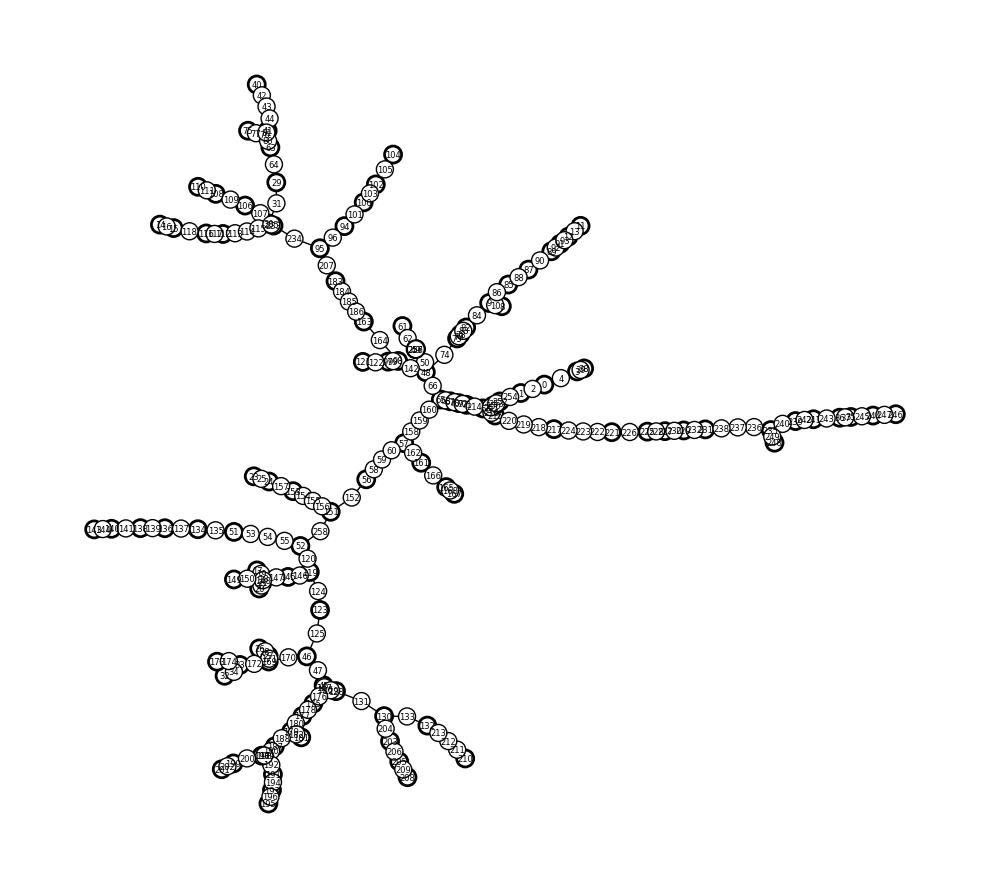

In [3]:
widthmap = [2 if 'boundary' in network.graph.nodes[node] else 1 for node in network.graph.nodes()]
plot_kwargs = {
    "font_size": 6,
    "node_size": 150,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": widthmap,
    "with_labels": True,
}
fig, ax = plt.subplots(1, 1, sharey=True, layout="tight", figsize=(10, 9))
pos = nx.kamada_kawai_layout(network.graph, weight="length")
nx.draw(network.graph, ax=ax, pos=pos, **plot_kwargs)
plt.show()

The boundary is a dictionary containing data from adjacent edges. The dictionary's keys contain the edge name and the data is the data that was in the reach end touching the node.

In [4]:
network.graph.nodes[130]["boundary"]

{'44l1':                          WaterLevel
 1994-08-07 16:35:00.000  193.645004
 1994-08-07 16:36:01.870  193.645142
 1994-08-07 16:37:07.560  193.645462
 1994-08-07 16:38:55.828  193.645950
 1994-08-07 16:39:55.828  193.646210
 ...                             ...
 1994-08-07 18:30:07.967  193.756149
 1994-08-07 18:31:07.967  193.756836
 1994-08-07 18:32:07.967  193.757462
 1994-08-07 18:33:07.967  193.758041
 1994-08-07 18:35:00.000  193.758957
 
 [110 rows x 1 columns],
 '45l1':                          WaterLevel
 1994-08-07 16:35:00.000  193.645004
 1994-08-07 16:36:01.870  193.645187
 1994-08-07 16:37:07.560  193.645523
 1994-08-07 16:38:55.828  193.646042
 1994-08-07 16:39:55.828  193.646301
 ...                             ...
 1994-08-07 18:30:07.967  193.756149
 1994-08-07 18:31:07.967  193.756821
 1994-08-07 18:32:07.967  193.757462
 1994-08-07 18:33:07.967  193.758041
 1994-08-07 18:35:00.000  193.758942
 
 [110 rows x 1 columns],
 '78l1':                          WaterLev

Network data (excluding boundaries) can be accessed as a DataFrame.

In [5]:
network.to_dataframe()

node,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
quantity,WaterLevel,WaterLevel,Discharge,WaterLevel,Discharge,WaterLevel,WaterLevel,Discharge,WaterLevel,WaterLevel,...,Discharge,WaterLevel,Discharge,WaterLevel,Discharge,Discharge,Discharge,WaterLevel,Discharge,Discharge
1994-08-07 16:35:00.000,195.441498,194.661499,0.000006,195.931503,0.000004,193.550003,193.550003,0.000000,195.801498,195.703003,...,0.000005,194.511505,0.000013,194.581497,0.000003,0.000002,0.000031,193.779999,0.000000,0.0
1994-08-07 16:36:01.870,195.441605,194.661621,0.000006,195.931595,0.000004,193.550140,193.550064,0.000008,195.801498,195.703171,...,0.000005,194.511841,0.000010,194.581497,0.000003,0.000002,0.000031,188.479996,0.000000,0.0
1994-08-07 16:37:07.560,195.441620,194.661728,0.000006,195.931625,0.000004,193.550232,193.550156,0.000016,195.801498,195.703400,...,0.000005,194.511795,0.000010,194.581497,0.000003,0.000002,0.000033,188.479996,0.000000,0.0
1994-08-07 16:38:55.828,195.441605,194.661926,0.000006,195.931656,0.000004,193.550369,193.550308,0.000022,195.801498,195.703690,...,0.000005,194.511581,0.000009,194.581497,0.000003,0.000002,0.000037,188.479996,0.000000,0.0
1994-08-07 16:39:55.828,195.441605,194.661972,0.000006,195.931656,0.000004,193.550430,193.550369,0.000024,195.801498,195.703827,...,0.000005,194.511505,0.000009,194.581497,0.000003,0.000002,0.000039,188.479996,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-08-07 18:30:07.967,195.470230,194.689072,0.000588,195.932449,0.000006,193.852173,193.850388,0.014644,195.802246,195.787277,...,0.000004,194.533127,0.000628,194.607559,0.000620,0.000605,0.026992,188.479996,0.033834,0.0
1994-08-07 18:31:07.967,195.470108,194.688934,0.000583,195.932419,0.000006,193.847687,193.845978,0.014039,195.801865,195.785614,...,0.000004,194.532974,0.000621,194.607407,0.000614,0.000600,0.025888,188.479996,0.029974,0.0
1994-08-07 18:32:07.967,195.469986,194.688812,0.000579,195.932373,0.000006,193.843384,193.841751,0.013460,195.802353,195.783936,...,0.000004,194.532822,0.000615,194.607254,0.000608,0.000595,0.024858,188.479996,0.026343,0.0


The network can also be expressed as a `xarray` Dataset.

In [5]:
ds = network.to_dataset()
ds

<xarray.Dataset> Size: 231kB
Dimensions:     (time: 110, node: 259)
Coordinates:
  * time        (time) datetime64[ns] 880B 1994-08-07T16:35:00 ... 1994-08-07...
  * node        (node) int64 2kB 0 1 2 3 4 5 6 7 ... 252 253 254 255 256 257 258
Data variables:
    Discharge   (time, node) float32 114kB nan nan 5.72e-06 ... nan 0.01692 0.0
    WaterLevel  (time, node) float32 114kB 195.4 194.7 nan ... 188.5 nan nan

### Mapping coordinates

Use `find()` to get generic network coordinates from original coordinates.

In [6]:
node_ids_in_res1d = ["100", "98"]
mapper.find(node=node_ids_in_res1d)

[0, 252]

We provide other ways to find elements, notice the slight change of nomenclature

- _reach_ becomes _edge_
- _chainage_ becomes _distance_

In [7]:
mapper.find(edge="100l1", distance=23.841)
mapper.find(edge="100l1", distance="start")

0

Finally, we can use `recall()` for the reverse mapping and get the former coordinates based on the current node id.

In [8]:
node_ids_in_generic_network = [34, 252]
mapper.recall(node_ids_in_generic_network)

[{'edge': '110l1', 'distance': 18.613}, {'node': '98'}]

### Integration with `modelskill`

The generic network enables seamless integration with `modelskill` while preserving original nomenclature.

In [9]:
# import modelskill as ms

mapper = NetworkMapper("../tests/testdata/network.res1d")
network = mapper.map_network()

items = mapper.find(edge="100l1", distance=23.841)
# items = mapper.find(node="99", at="100l1")  # Find the values at node "99" at the boundary with "100l1"

# sensors = ms.NetworkObservation(path_to_csv, item=items)  # items is as long as the number of columns in the csv
# model = ms.NetworkModelResult(network)
# cmp = ms.match(sensors, model)

## Appendix: Architecture

![architecture](../images/docs/classes_format_mapper.png)